In [1]:
from dataclasses import dataclass
import jax
import jax.numpy as jnp
from elegy.pytree import Pytree
import elegy as eg
import numpy as np
from IPython import get_ipython


@dataclass
class Config:
    dataset: str = "moons"
    batch_size: int = 32
    epochs: int = 10
    steps_per_epoch: int = 15_000
    lr: float = 1e-3


config = Config()

if __name__ == "__main__" and not get_ipython():
    from ml_collections import config_flags
    from absl import flags
    import sys

    config_flag = config_flags.DEFINE_config_dataclass("config", config)
    flags.FLAGS(sys.argv)
    config = config_flag.value

In [2]:
def expand_to(a, b):
    new_shape = a.shape + (1,) * (b.ndim - a.ndim)
    return a.reshape(new_shape)


class Diffusion(Pytree):
    betas: jnp.ndarray
    alpha_bars: jnp.ndarray

    def __init__(self, betas: jnp.ndarray) -> None:
        self.betas = betas
        self.alphas = 1.0 - betas
        self.alpha_bars = jnp.cumprod(self.alphas)

    def forward_diffusion(self, key, x0, t):
        alpha_bars = expand_to(self.alpha_bars[t], x0)
        noise = jax.random.normal(key, x0.shape)
        xt = jnp.sqrt(alpha_bars) * x0 + jnp.sqrt(1.0 - alpha_bars) * noise
        return xt, noise

    def backward_diffusion(self, key, xT, pred_noise, t):
        betas = expand_to(self.betas[t], xT)
        alphas = expand_to(self.alphas[t], xT)
        alpha_bars = expand_to(self.alpha_bars[t], xT)

        sampling_noise = jnp.sqrt(betas) * jax.random.normal(key, xT.shape)
        pred_noise = betas / jnp.sqrt(1.0 - alpha_bars) * pred_noise
        xT_minus1 = (xT - pred_noise) / jnp.sqrt(alphas)

        return jnp.where(t[:, None] == 0, xT_minus1, xT_minus1 + sampling_noise)

In [3]:
def get_data(dataset: str = "moons"):
    from sklearn.datasets import make_moons, make_blobs
    from sklearn.preprocessing import MinMaxScaler

    if dataset == "moons":
        X, y = make_moons(n_samples=1000, noise=0.1, random_state=0)
    elif dataset == "blobs":
        X = make_blobs(n_samples=1000, centers=6, cluster_std=0.5, random_state=6)[0]
    else:
        raise ValueError(f"Unknown dataset: {dataset}")

    X = MinMaxScaler((-1, 1)).fit_transform(X)
    return X

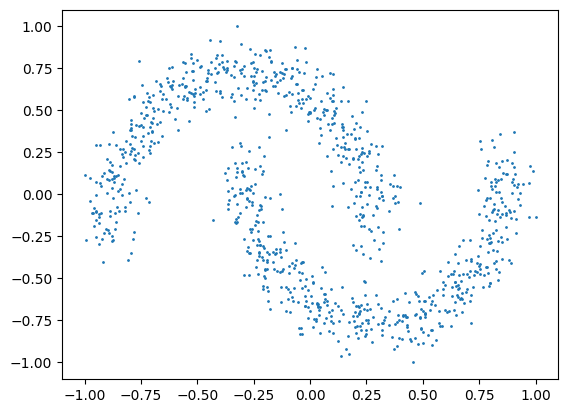

In [4]:
import matplotlib.pyplot as plt


def draw_fn():
    if not get_ipython():
        plt.ion()
        plt.pause(0.5)
        plt.ioff()
    else:
        plt.show()


X = get_data(config.dataset)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=1)
draw_fn()

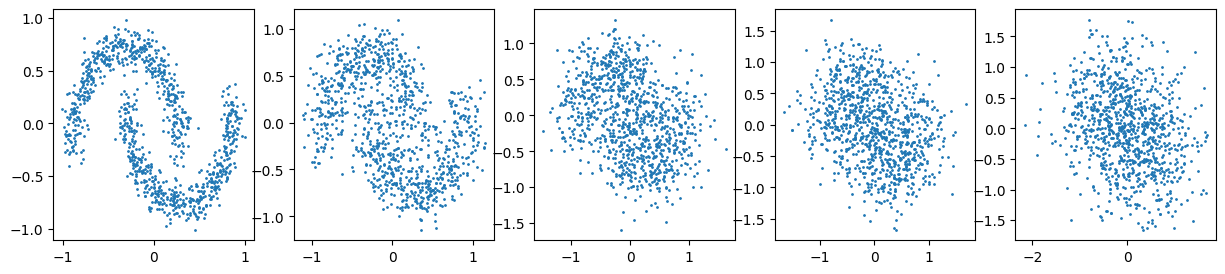

In [5]:
num_steps = 50
betas = jnp.linspace(0.0001, 0.01, num_steps)
diffusion = Diffusion(betas)

_, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, ti in enumerate(jnp.linspace(0, 49, 5).astype(int)):
    t = jnp.full((X.shape[0],), ti)
    xt, noise = diffusion.forward_diffusion(jax.random.PRNGKey(ti), X, t)
    axs[i].scatter(xt[:, 0], xt[:, 1], s=1)

draw_fn()

In [6]:
import flax.linen as nn
from flax.training.train_state import TrainState
import optax


class SinusoidalPosEmb(nn.Module):
    dim: int

    def __call__(self, t):
        half_dim = self.dim // 2
        mul = jnp.log(10000) / (half_dim - 1)
        emb = jnp.exp(-mul * jnp.arange(half_dim))
        emb = t[:, None] * emb[None, :]
        emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
        return emb


class TimeConditionedDense(nn.Module):
    units: int
    emb_dim: int

    @nn.compact
    def __call__(self, x, t):
        t_embeddings = SinusoidalPosEmb(self.emb_dim)(t)
        x = jnp.concatenate([x, t_embeddings], axis=-1)
        x = nn.Dense(self.units)(x)
        return x


class Denoiser(nn.Module):
    units: int = 128
    emb_dim: int = 32

    @nn.compact
    def __call__(self, x, t):
        inputs_units = x.shape[-1]
        x = TimeConditionedDense(self.units, self.emb_dim)(x, t)
        x = nn.relu(x)
        x = TimeConditionedDense(self.units, self.emb_dim)(x, t)
        x = nn.relu(x)
        x = TimeConditionedDense(inputs_units, self.emb_dim)(x, t)
        return x


@dataclass
class DDPM(eg.CoreModule):
    diffusion: Diffusion
    state: TrainState
    metrics: eg.Metrics
    key: jnp.ndarray
    steps: int = eg.static_field()

    def init_step(self, key, batch):
        return self

    @jax.jit
    def predict_step(self, batch, batch_idx):
        x_shape_source, key = batch
        x = jax.random.uniform(key, x_shape_source.shape, minval=-1, maxval=1)

        def scan_fn(carry, t):
            x, key = carry
            backward_key, key = jax.random.split(key)
            t = jnp.full((x.shape[0],), t)
            pred_noise = self.state.apply_fn({"params": self.state.params}, x, t)
            x = self.diffusion.backward_diffusion(backward_key, x, pred_noise, t)
            return (x, key), x

        ts = jnp.arange(self.steps, 0, -1)
        _, xs = jax.lax.scan(scan_fn, (x, key), ts)
        return xs, self

    def loss_fn(self, params, key, x):
        key_t, key_diffusion = jax.random.split(key, 2)
        t = jax.random.uniform(
            key_t, (x.shape[0],), minval=0, maxval=self.steps
        ).astype(jnp.int32)
        xt, noise = self.diffusion.forward_diffusion(key_diffusion, x, t)
        noise_pred = self.state.apply_fn({"params": params}, xt, t)
        return jnp.mean((noise - noise_pred) ** 2)

    @jax.jit
    def train_step(self, batch, batch_idx, epoch_idx):
        x = batch
        loss_key, key = jax.random.split(self.key)
        loss, grads = jax.value_and_grad(self.loss_fn)(self.state.params, loss_key, x)
        state = self.state.apply_gradients(grads=grads)
        metrics = self.metrics.update(loss=loss)
        logs = metrics.compute()
        return logs, self.replace(state=state, metrics=metrics, key=key)

    def on_epoch_end(self, epoch: int, logs=None):
        x = jnp.empty((1000, 2))
        xs, _ = self.predict_step((x, self.key), 0)
        _, axs = plt.subplots(1, 5, figsize=(15, 3))
        for i, ti in enumerate(jnp.linspace(0, 49, 5).astype(int)):
            axs[i].scatter(xs[ti][:, 0], xs[ti][:, 1], s=1)
        draw_fn()
        return self


module = Denoiser()
variables = module.init(jax.random.PRNGKey(42), X[:1], jnp.array([0]))
tx = optax.adam(config.lr)
state = TrainState.create(apply_fn=module.apply, params=variables["params"], tx=tx)
metrics = eg.Metrics(eg.metrics.Mean(name="loss").map_arg(loss="values")).init()
ddpm = DDPM(diffusion, state, metrics, steps=num_steps, key=jax.random.PRNGKey(42))

Epoch 1/10


/data/cristian/simple-ddpm/.venv/lib/python3.8/site-packages/elegy/data/utils.py:199: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  sizes: tp.Set[int] = set(x.shape[0] for x in jax.tree_leaves(batch_elems))


14532/15000 [============================>.] - 17s 1ms/step - loss: 0.7206: 18s  - ETA: 17s - loss: 0.76 - ETA: 16s - loss: 0. - ETA: 16s - loss:  - ETA: 16s - loss: 0.76 - ETA: 15s - loss: 0.76 - ETA: 15s - loss: 0.76 - ETA: 15s  - ETA: 10s - loss: 0.74 - ETA: 10s - loss:  - ET - ETA: 9s - loss: 0.7 - ETA: 8s - loss: 0.73 - ETA: 8s - loss: 0.73 - ETA: 8s - loss: 0. - ETA: 8s - loss: 0.73 - ETA: 8s - loss: 0.73 - ETA: 8s - loss: 0. - ETA: 7s - loss: 0. - ETA: 7s - loss: 0. - ETA: 7s - loss: 0 - ETA: 6s - loss: 0.732 - ETA: - ETA: 5s - loss: 0.729 - ETA: 5s - loss: 0. - ETA: 5s - loss: 0.728 - ETA: 5s - loss: 0. - ETA: 4s - loss: 0.728 - ETA: 4s - loss: 0.7 - ETA: 4s - loss: 0.727 - ETA: 4s - loss: 0.7 - ETA: 4s - loss: 0.726 - ETA: 4s - loss: 0.7 - ETA: 4s - loss: 0. - ETA: 3s - loss: 0. - ETA: 3s - los - ETA: 1s - loss - ETA: 1s - loss: 0.721 - ETA: 1s - loss: 0.72 - ETA: 0s - loss: 0. - ETA: 0s - loss: 0.


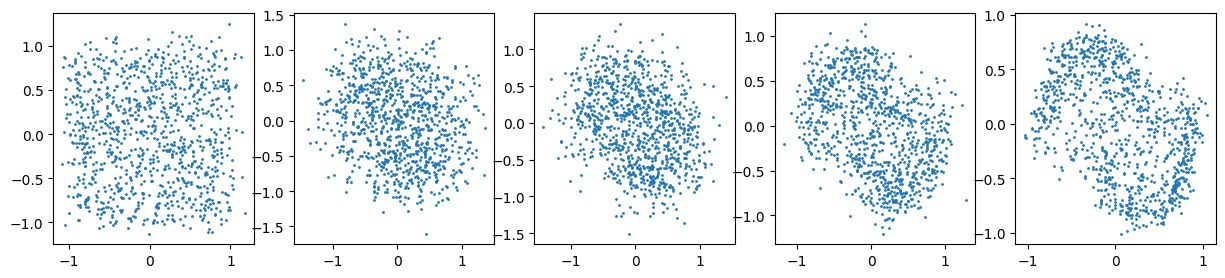

Epoch 2/10
14531/15000 [============================>.] - 14s 975us/step - loss: 0.682815s - loss: 0.69 - ETA: 15s - loss - ETA:  - ETA: 14s - loss - ETA: 13s - loss:  - ETA: 13s - loss: 0.69 - ETA: 13s - loss:  - ETA: 13 - ETA: 12s - loss - E - ETA: 11s - loss: 0.69 - ETA: 11s - loss: 0.69 - ETA: 11s - loss: 0. - ETA: 11s - loss: 0.69 - ETA: 11s - loss: 0.69 - ETA: 11s - loss - ETA: 11s - lo - ETA: 10s - loss:  - E - ETA: 9s - loss: 0.690 - ETA: 9s - loss: 0.689 - ETA: 9s - loss: 0.6 - ETA: 9s - loss: 0.689 - ETA: 9s - loss: 0. - ETA: 9s - loss: 0.68 - ETA: 9s - loss: 0.689 - ETA: 9s - loss: 0.689 - ETA: 8s - loss: 0.6 - ETA: 8s - loss: 0.688 - ETA: 8s - loss: 0.6 - ETA: 8s -  - ETA: 8s - loss: 0.68 - ETA: 7s - loss: 0.68 - ETA: 7s - loss: 0.687 - ETA: 7s - loss: 0.687 - ETA: 7s - loss: 0. - ETA: 7s - loss: 0.687 - ETA: 7s - loss: 0.6 - ETA: 7s - loss: 0.687 - ETA: 7s - loss: 0.687 - ETA: 7s - loss: 0.6 - ETA: 7s - loss: 0.687 - ETA: 7s - loss: 0.6 - ETA: 6s - loss: 0.686 - ETA: 6s - 

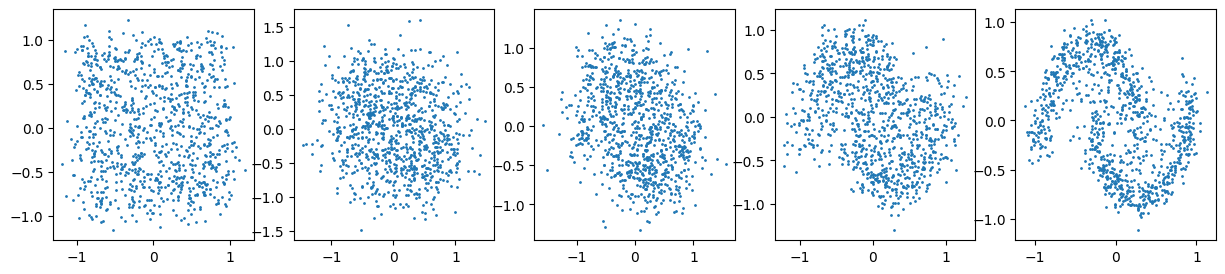

Epoch 3/10
14531/15000 [============================>.] - 15s 1ms/step - loss: 0.6772: 12s - loss: 0.68 - ETA: 12s -  - ETA: 12s - loss: 0. - ETA:  - ETA: 11s - loss: 0.68 - ETA: 11s - loss: 0. - ETA: 11s - loss: 0.68 - ETA: 11s - loss - ETA:  - ETA: 10s - loss: 0.68 - ETA: 10s - loss: 0.68 - ETA: 10s - loss:  - ETA: 10s - loss - ETA: 10s - loss: 0. - ETA: 9s - loss - ETA: 9s - loss: 0 - ETA: 9s - lo - ETA: 8s - loss: 0.679 - ETA: 8s - loss: 0. - ETA: 8s - loss: 0. - ETA: 8s - loss: 0.6 - ETA: 8s - loss: 0.679 - ETA: 8s - l - ETA: 7s - lo - ETA: 7s - loss: 0. - ETA: 6s - loss: 0. - ET - ETA: 5s - loss: 0.67 - ETA: 5s - loss: 0.67 - ETA: 5s - loss: 0.67 - ETA: 5s - loss: 0.67 - ETA: 4s - ETA: 4s - loss: 0. - ETA: 3s - loss: 0. - ETA: 3s - loss: 0 - ETA: 3s - loss: 0.6 - ETA: 3s - loss: 0. - E - ETA: 1s - loss: 0.677 - ETA: 1s - loss: 0.677 - ETA: 1s - los - ETA: 1s - loss: 0.67 - ETA: 1s - loss: 0.677 - ETA: 0s - loss: 0.677 - ETA: 0s - loss: 0.677 - ETA: 0s - loss: 0.67 - ETA: 0s - los

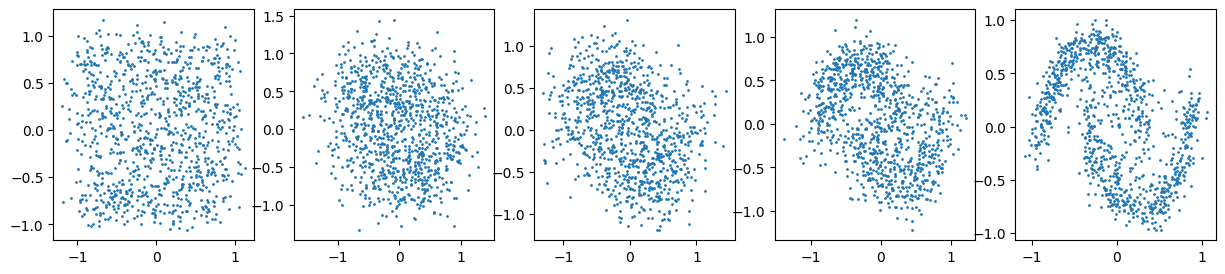

Epoch 4/10
14531/15000 [============================>.] - 14s 977us/step - loss: 0.674313s - loss: 0.67 - ETA: 13s - loss: 0.67 - ETA: 13s - loss: 0. - ETA: 12s - loss: 0.67 - ETA: 12s - loss: 0.67 - ETA: 12s - loss: 0.67 - ETA: 12s - loss: 0.67 - ETA: 12s - loss: 0.67 - ETA: 12s - loss: 0.67 - ETA: 12s - loss:  - ETA: 12s - loss - ETA: 12s - loss - ETA: 11s - loss - ETA: 11s - loss - ETA: 11s - loss - ETA: 11s - loss - ETA: 10s - - ETA: 8s - loss: 0.676 - ETA: 8s - loss: 0.676 - ETA: 8s - loss: 0.676 - ETA: 8s - loss: 0.6 - ETA: 7s - loss: 0.675 - ETA: 7s - loss: 0.67 - ETA: 7s - loss: 0. - ETA: 7s - loss: 0.675 - ETA: 6s - loss: 0. - ETA: 6s - loss: 0. - ETA: 6s - loss: 0.67 - ETA: 6s - loss: 0.675 - ETA: 6s - loss: 0.675 - ETA: 6s - loss: 0.6 - ETA: 6s - loss: 0.67 - ETA: 6s - loss: 0.67 - ETA: 6s - loss: 0.67 - ETA: 5s - loss: 0. - ETA: 5s - loss: 0. - ETA - ETA: 4s - loss: 0.6 - ETA: 4s - loss: 0.675 - ETA: 4s - loss: 0.675 - ETA: 4s - loss: 0.675 - ETA: 4s - loss: 0.675 - ETA: 4s

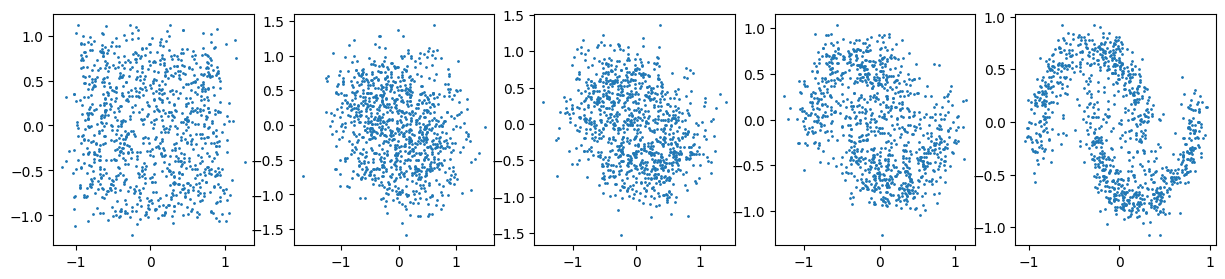

Epoch 5/10
14532/15000 [============================>.] - 15s 1ms/step - loss: 0.6724: 17s - loss - ETA: 16s - loss - ETA: 16s - loss: 0.67 - ETA: 16s - loss: 0. - ETA: 15s - loss: 0.67 - ETA: 15s - loss: 0. - ETA: 15s - loss: 0.67 - ETA: 15s - loss: 0.67 - ETA: 15s - loss: 0. - ETA: 14s - loss:  - ETA: 14s - loss: 0.67 - ETA: 14 - ETA: 10s - loss: - ETA: 9s - los - ETA: 9s - loss: 0. - ETA: 9s - loss: 0.673 - ETA: 8s - loss: 0.6 - ETA: 8s - loss: 0. - ETA: 8s - loss: 0. - ETA: 8s - loss: 0.6 - ETA: 8s - loss: 0.673 - ETA: 8s - loss: 0.6 - ETA: 7s - loss: 0.673 - ETA: 7s - loss: 0.6 - ETA: 7s - loss: 0.673 - ETA: 7s - loss: 0. - ETA: 7s - loss: 0.6 - ETA - ETA: 6s - loss: 0.6 - ETA: 6s - loss: 0.673 - ETA: 6s - loss: 0. -  - ETA: 4s - loss: 0.672 - ETA: 4s - loss: - ETA: 4s - -  - ETA: 2s - loss: 0.67 - ETA: 2s - loss: 0.672 - ETA: 2s - loss: 0.6 - ETA: 2s - loss: - ETA: 2s - loss - ETA: 1s - loss: 0.672 - ETA: 1s - loss: 0. - ETA: 1s - loss: 0. - ETA: 1s - loss: 0. - ETA: 1s - loss: 0

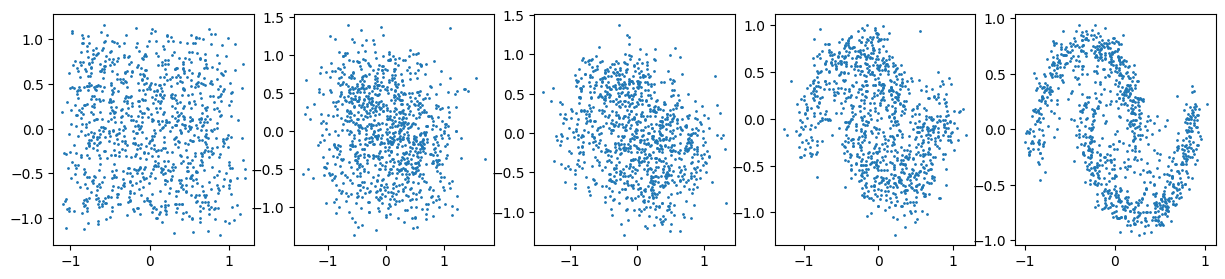

Epoch 6/10
14531/15000 [============================>.] - 14s 982us/step - loss: 0.670615s - loss: 0.67 - ETA: 15s - loss: 0. - ETA: 15s - loss: 0.67 - ETA: 15s - loss:  - ETA: 15s - loss: 0. - ETA: 14s - loss: 0. - ETA: 14s - loss - ETA: 13s - loss: 0. - ETA: 13s - loss: 0. - ETA: 13s - loss: 0. - ETA: 12s - loss - ETA: 11s - loss - ETA: 11s - loss - ETA: 11s  - ETA: 10s - loss - ETA: 10s - loss: 0. - ETA: 9s - loss: 0.671 - ETA: 9s - loss: 0.67 - ETA: 9s - loss: 0.67 - ETA: 9s - loss: 0.67 - ETA: 9s - loss: 0.67 - ETA: 9s - loss: 0.67 - ETA: 9s - loss: 0.67 - ETA: 9s - loss: 0.67 - ETA: 9s - loss: 0.6 - ETA: 8s - loss: 0.671 - ETA: 8s - loss: 0.6 - ETA: 8s - loss - ETA: 8s - loss: 0.67 - ETA: 8s - loss: 0.67 - ETA: 8s - loss: 0.671 - ETA: 8s - loss: 0.671 - ETA: 8s - loss: 0.671 - ETA: 8s - loss: 0.671 - ETA: 8s - loss: 0.671 - ETA: 7s - loss: 0.67 - ETA: 7s - loss: 0. - ETA: 7s - loss: - ETA: 7s - loss: 0. - ETA: 6s - loss: 0.67 - ETA: 6s - loss: - ETA: 6s - loss: 0.671 - ETA: 6s - 

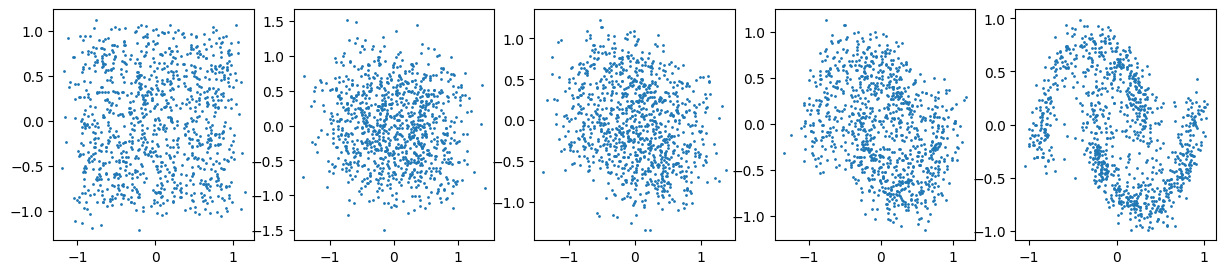

Epoch 7/10
14531/15000 [============================>.] - 15s 998us/step - loss: 0.669112s - loss - ETA: 11s - loss - ETA - ETA: 11s  - ETA: 11s - loss: 0.67 - ETA: 11s - loss:  - ETA: 11s - loss: 0.67 - ETA: 10s - loss: 0.67 - ETA: 10s - loss: 0.67 - ETA: 10s - loss: 0.67 - ETA: 10s - loss - ETA: 10s - loss: 0.67 - ETA: 10s - loss: 0.67 - ETA: 10s - loss: 0.67 - ETA: 10s - loss: 0.67 - ETA: 10s - loss: 0. - ETA: 10s - loss:  - ETA: 10s - loss: 0.67 - ETA: 10s - - ETA: 9s - loss: 0. - ETA: 9s - loss: 0 - ETA: 9s - loss: 0.669 - ETA: 9s - loss: 0.66 - ETA: 9s - loss: 0.66 - ETA: 9s - lo - ETA: 8s - loss: 0.66 - ETA: 8s - loss: 0.66 - ETA: 8s - loss: 0. - ETA: 8s - loss: 0.66 - ETA: 8s - loss: 0.669 - ETA: 7s - loss: 0.669 - ETA: 7s - loss: 0.6 - ETA: 7s - loss: 0. - ETA: 7s - loss: 0.669 - ETA: 7s - lo - ETA: 6s - loss: 0.669 - ETA: 6s - loss: 0.669 - ETA: 6s - loss: 0.669 - ETA: 6s - loss: 0.66 - ETA: 6s - loss: 0.66 - ET - ETA: 4s - loss: 0.66 - ETA: 4s - loss: 0.66 - ETA: 4s - loss: 

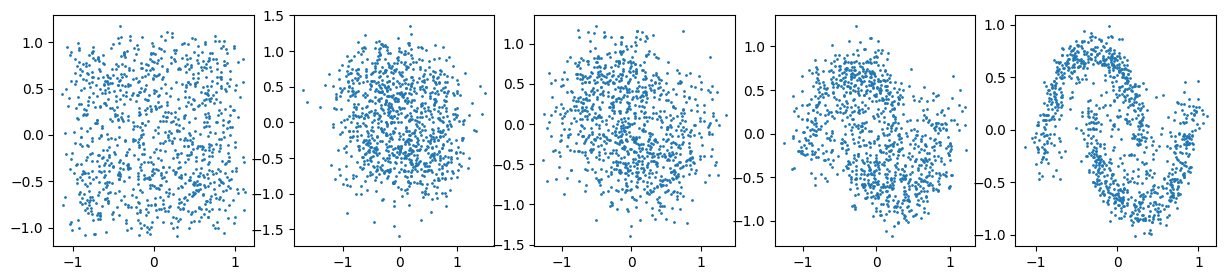

Epoch 8/10
14531/15000 [============================>.] - 14s 991us/step - loss: 0.668013s - loss: 0. - ETA: 13s - lo - ETA: 12s - loss: 0.66 - ETA: 12s - loss:  - ETA: 12s - loss - ETA: 12s - loss: 0.66 - ETA: 12s - loss: 0.66 - ETA: 12s - loss: 0.66 - ETA: 11s - loss: 0.66 - ETA: 11s - loss: 0. - ETA: 11s - loss: 0.66 - ETA: 11s -  - ETA: 11s - loss: 0.66 - ETA: 11s - loss:  - ETA: 10s - loss - ETA: 10s - loss:  - ETA: 10s - loss: 0.66 - ETA: 10s - loss: 0. - ETA: 10s - loss: 0. - ETA: 10s - loss: 0. - ETA: 10s - loss: - ETA: 9s - loss: 0.6 - ETA: 9s - loss: 0.668 - ETA: 9s - loss: 0.6 - ETA: 9s - loss: 0.668 - ETA: 9s - loss: 0.6 - ETA: 9s - loss: 0 - ETA: 9s - loss: 0.66 - ETA: 8s - los - ETA: 8s - loss: 0.668 - ETA: 8s - loss: 0.66 - ETA: 8s - loss: 0.6 - ETA: 8s - loss: 0.668 - ETA: 8s - loss: 0.6 - ETA: 7s - loss: 0.668 - ETA: 7s - loss: 0.668 - ETA: 7s - loss: 0.668 - ETA: 7s - loss: 0.668 - ETA: 7s - loss: 0.668 - ETA: 7s - loss: 0.668 - ETA: 7s - loss: 0.66 - ETA: 7s - loss: 

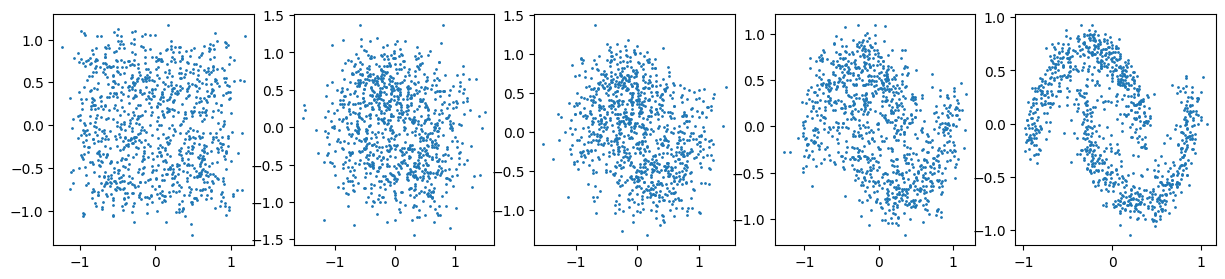

Epoch 9/10
14532/15000 [============================>.] - 14s 990us/step - loss: 0.667014s - loss - ETA: 12s - loss: 0.66 - ETA: 12s - loss:  - ETA: 12s - loss: 0.66 - ETA: 12s - loss: 0. - ETA: 12s - loss:  - ETA: 12s - loss: 0.66 - ETA: 12s - loss:  - ETA: 12s - loss - ETA: 11s  - ETA: 12s - loss:  - ETA: 11s - loss: 0.66 - ETA: 11s - lo - ETA: 11s - loss - ETA: 11s - loss - ETA: 11s - loss: 0.66 - ETA: 11s - loss: 0.66 - ETA: 10s - lo - ETA: 9s - loss: 0.667 - ETA: 9s - loss: 0.667 - ETA: 9s - loss: 0.667 - ETA: 9s - loss: 0.667 - ETA: 9s - loss: 0.667 - ETA: 9s - loss: 0.667 - ETA: 9s - loss: 0.6 - ETA: 9s - loss: 0.667 - ETA: 9s - loss: 0.66 - ETA: 9s - loss: 0.667 - ETA: 8s - loss: 0.667 - ETA: 8s - loss: 0.667 - ETA: 8s - loss: 0.6 - ETA: 8s - loss: 0.667 - ETA: 8s - loss: 0.6 - ETA: 8s - loss: 0.667 - ETA: 8s - loss: 0. - ETA: 8s - loss: 0. - ETA: 8s - loss: 0. - ETA: 7s - loss: 0 - ETA: 7s - loss: 0.6 - ETA: 7s - loss: 0.667 - ETA: 7s - loss: 0.6 - ETA: 7s - loss: 0.667 - ETA:

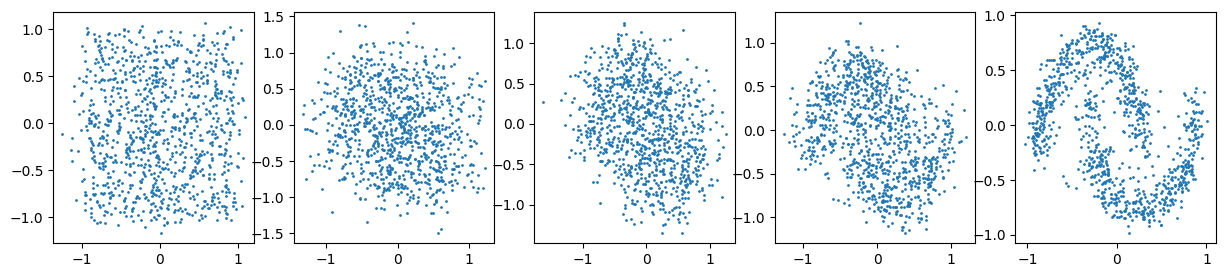

Epoch 10/10
14531/15000 [============================>.] - 14s 989us/step - loss: 0.666413s - loss: 0.66 - ETA: 13s - loss: 0.66 - ETA: 13s - loss: 0.66 - ETA: 13s - lo - ETA: 12s - loss: 0. - ETA: 12s - lo - ETA: 12s - loss: 0.66 - ETA: 12s  - ETA: 10s - loss: 0.66 - ETA: 10s - loss: 0.66 - ETA: 10s - loss: 0. - ETA: 9s - loss: 0.666 - ETA: 9s - loss: 0.66 - ETA: 9s -  - ETA: 8s - loss: 0.666 - ETA: 8s - los - ETA: 8s - loss: 0. - ETA: 8s - loss: 0. - ETA: 8s - loss: 0. - ETA: 7s - loss: 0. - ETA: 7s - loss: 0. - ETA: 7s - loss: 0 - ETA: 7s - loss: 0.666 - ETA: 7s - loss: 0.666 - ETA: 7s - loss: 0.666 - ETA: 7s - loss: 0.6 - ETA:  - ETA: 6s - loss: - ETA: 5s - loss: 0.6 - ETA: 5s - loss: 0 - ETA: 5s - loss: 0.666 - ETA: 5s - loss: 0.6 - ETA: 5s - loss: 0.6 - ETA: 5s - loss: 0.666 - ETA: 4s - loss: 0.666 - ETA: 4s - loss: 0.66 - ETA: 4s - loss: 0.666 - ETA: 4s - loss: 0.666 - ETA: 4s - loss: 0.666 - ETA: 4s - loss: 0. - ETA: 4s - loss: 0. - ETA: 4s - l - ETA: 2s - loss: 0.666 - ETA: 2s

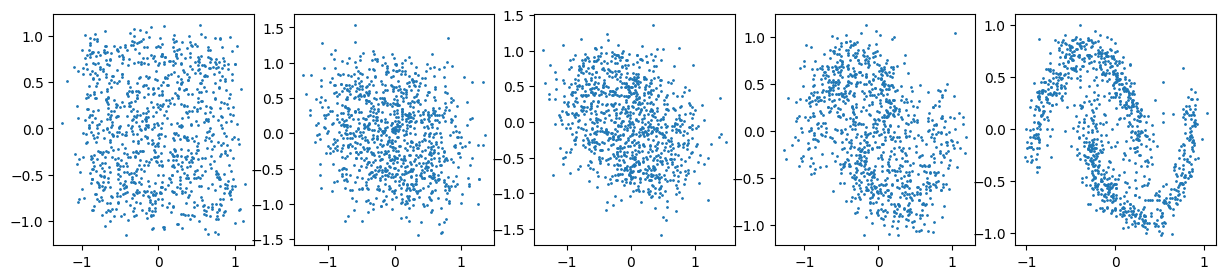

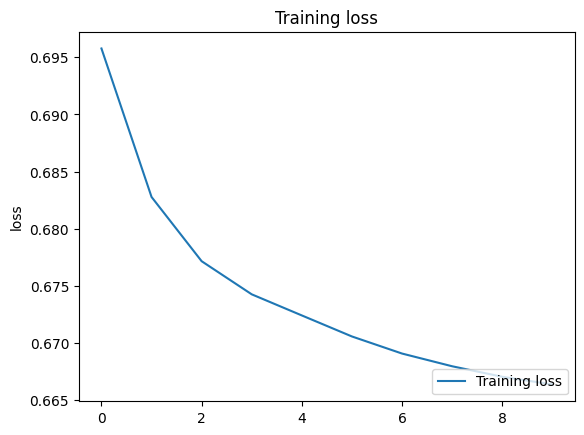

In [7]:
from elegy.utils import plot_history

trainer = eg.Trainer(ddpm)
history = trainer.fit(
    X,
    batch_size=config.batch_size,
    epochs=config.epochs,
    steps_per_epoch=config.steps_per_epoch,
)

plt.figure()
plot_history(history)


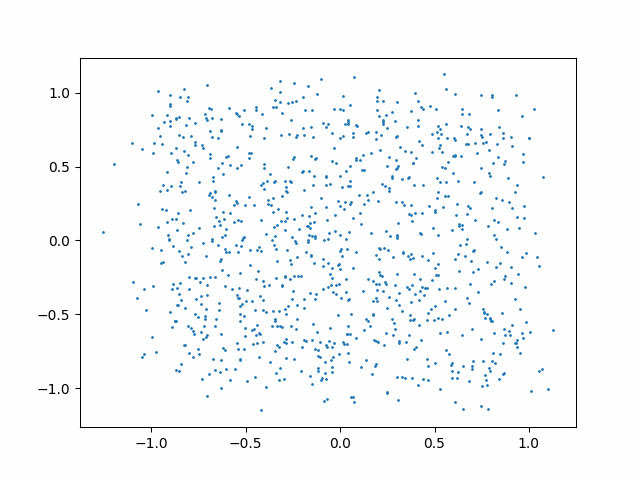

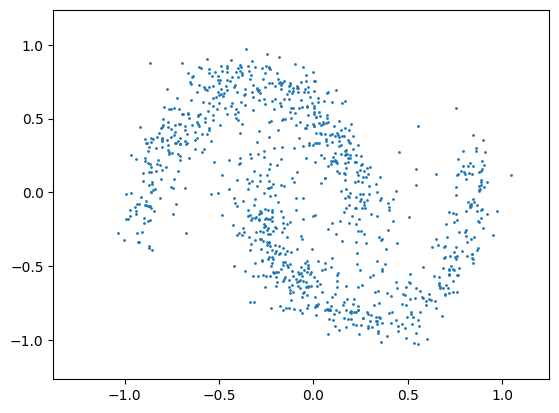

In [8]:
def plot_trajectory(
    xs: np.ndarray,
    interval: int = 10,
    repeat_delay: int = 1000,
    step_size: int = 1,
    end_pad: int = 500,
):
    from pathlib import Path
    from tempfile import TemporaryDirectory
    from matplotlib import animation
    from IPython import get_ipython
    from IPython.display import HTML, display
    from base64 import b64encode
    from einop import einop

    xs = xs[::step_size]

    # replace last sample to create a 'pause' effect
    pad_end = einop(xs[-1], "... -> batch ...", batch=end_pad)
    xs = np.concatenate([xs, pad_end], axis=0)

    N = len(xs)

    fig = plt.figure()
    scatter = plt.scatter(xs[0][:, 0], xs[0][:, 1], s=1)

    def animate(i):
        scatter.set_offsets(xs[i])
        return [scatter]

    anim = animation.FuncAnimation(
        fig,
        animate,
        init_func=lambda: animate(0),
        frames=np.linspace(0, N - 1, N, dtype=int),
        interval=interval,
        repeat_delay=repeat_delay,
        blit=True,
    )

    if get_ipython():
        with TemporaryDirectory() as tmpdir:
            img_name = Path(tmpdir) / f"diffusion.gif"
            anim.save(str(img_name), writer="pillow", fps=60)
            image_bytes = b64encode(img_name.read_bytes()).decode("utf-8")

        display(HTML(f"""<img src='data:image/gif;base64,{image_bytes}'>"""))
    else:
        pass

    return anim


ddpm = trainer.module
x = jnp.empty((1000, 2))
xs = ddpm.predict_step((x, ddpm.key), 0)[0]

if get_ipython():
    anim = plot_trajectory(xs, step_size=2)
else:
    anim = plot_trajectory(xs, step_size=2, interval=100, repeat_delay=1000, end_pad=0)

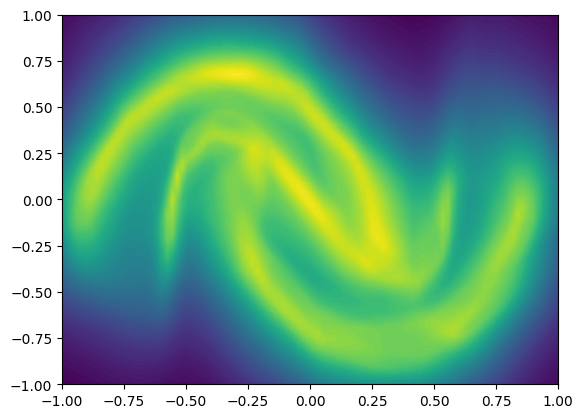

In [9]:
def plot_density(module: DDPM, ts):
    t = jnp.array(ts)
    x = jnp.linspace(-1, 1, 100)
    y = jnp.linspace(-1, 1, 100)
    xx, yy = jnp.meshgrid(x, y)
    X = jnp.stack([xx, yy], axis=-1)

    def mass_fn(x, t):
        t_ = jnp.full((1,), t)
        x_ = x[None]
        # pred_noise = density_gradient
        density_gradient = module.state.apply_fn(
            {"params": module.state.params}, x_, t_
        )
        magnitud = jnp.linalg.norm(density_gradient, axis=-1, keepdims=False)
        mass = jnp.exp(-magnitud)
        return mass[0]

    mass_fn = jax.jit(
        jax.vmap(
            jax.vmap(jax.vmap(mass_fn, in_axes=(0, None)), in_axes=(0, None)),
            in_axes=(None, 0),
            out_axes=-1,
        )
    )
    mass = mass_fn(X, t).mean(axis=-1)
    plt.contourf(xx, yy, mass, levels=100)


plt.figure()
plot_density(ddpm, [0, 10, 20])

In [10]:
plt.ioff()
plt.show()